In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 

Populating the interactive namespace from numpy and matplotlib


In [2]:

def shell_run_and_wait(command):
    print command
    command = command.split(" ")
    import subprocess
    #process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    process = subprocess.Popen(command)
    process.wait()
    return process.returncode


In [3]:
sys.path.insert(0,'/opt/R/R-3.4.2-intel-mkl/bin')

In [4]:
if os.path.exists('/opt/R/R-3.4.2-intel-mkl/bin/Rscript'):
    RCMD='/opt/R/R-3.4.2-intel-mkl/bin/Rscript'
else:
    RCMD=!which Rscript
    assert RCMD
    RCMD=RCMD[0]

In [5]:
master = pd.read_csv('https://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_master.csv')

In [6]:
master['level'].value_counts()

MSA                       73594
State                     24312
USA or Census Division     7200
Puerto Rico                 186
Name: level, dtype: int64

In [7]:
master['hpi_type'].value_counts()

traditional      99427
non-metro         4371
distress-free     1308
developmental      186
Name: hpi_type, dtype: int64

In [8]:
def read_po_monthly_hpi():
    df=master[(master['frequency']=='monthly') & (master['hpi_flavor']=='purchase-only')  & (master['hpi_type']=='traditional')]
    df['month'] = df[['yr','period']].apply(lambda u: pd.to_datetime('{}-{}-1'.format(u.values[0],u.values[1])),axis=1)
    df=pd.pivot_table(df,index=['month'], columns=['place_id'],values=['index_nsa'] )
    df.columns = df.columns.droplevel()
    df.columns=df.columns.map(lambda u: u.replace("DV_",""))
    #df=df[["MA",'ENC','WNC','SA','PAC']]    
    return df 

In [9]:
div_po_monthly=read_po_monthly_hpi()

/home/bo/miniconda2/envs/python27/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [10]:
from dateutil.relativedelta import relativedelta

In [11]:
div_po_monthly.tail()

place_id       ENC     ESC      MA      MT      NE     PAC      SA     WNC  \
month                                                                        
2018-01-01  211.86  233.55  231.84  343.10  245.12  299.43  260.89  254.60   
2018-02-01  213.65  235.71  231.83  346.86  246.28  304.95  263.69  255.42   
2018-03-01  216.83  238.59  236.28  351.29  246.68  307.16  267.23  260.58   
2018-04-01  220.21  239.54  235.35  355.94  251.14  309.77  270.49  262.66   
2018-05-01  221.15  245.62  238.22  359.09  254.78  311.79  272.81  264.93   

place_id       WSC     USA  
month                       
2018-01-01  270.00  257.11  
2018-02-01  276.33  259.93  
2018-03-01  278.01  263.13  
2018-04-01  278.24  265.40  
2018-05-01  282.61  268.13

In [12]:
def do_predict(div_po_monthly):
    div_po_monthly=div_po_monthly.copy()
    inputfile="/tmp/div_po_monthly.csv"
    outputfile= inputfile+".rpred"
    div_po_monthly.to_csv(inputfile)
    code=shell_run_and_wait("{} ./arimmaforeast.R --input {} --output {} --freq 12 --nthread 2".format(RCMD,inputfile,outputfile))
    assert code==0, code
    pred=pd.read_csv(outputfile,header=None).values
    print pred.shape
    assert np.isnan(pred).sum()==0
    max_month=div_po_monthly.index.max()
    for i in range(pred.shape[0]):
        max_month=max_month+relativedelta(months=1)
        div_po_monthly.loc[max_month]=pred[i]
    return div_po_monthly.sort_index()

In [13]:
new_div_po_monthly=do_predict(div_po_monthly)

/opt/R/R-3.4.2-intel-mkl/bin/Rscript ./arimmaforeast.R --input /tmp/div_po_monthly.csv --output /tmp/div_po_monthly.csv.rpred --freq 12 --nthread 2
(12, 10)


In [14]:
new_div_po_monthly.tail()

place_id           ENC         ESC          MA          MT          NE  \
month                                                                    
2019-01-01  224.616017  250.298401  243.296286  379.553173  262.334873   
2019-02-01  224.989097  250.592213  244.031448  381.818850  262.821347   
2019-03-01  225.361886  251.063681  244.545063  384.025729  263.307814   
2019-04-01  225.734541  251.666447  245.239582  386.175337  263.794281   
2019-05-01  226.107133  252.315150  245.757044  388.269159  264.280749   

place_id           PAC          SA         WNC         WSC         USA  
month                                                                   
2019-01-01  323.645583  286.217860  266.762993  292.928676  278.004577  
2019-02-01  324.727838  287.667211  267.323172  294.134185  278.676454  
2019-03-01  325.757617  289.071338  267.921818  295.339695  279.311178  
2019-04-01  326.741512  290.431654  268.513093  296.545204  279.918514  
2019-05-01  327.685287  291.749525  269.083049  297.750713  280.505662

In [15]:
new_div_po_monthly.to_csv("../input/third2/HPI_PO_monthly_hist_with_forecast_arima.csv")

ENC


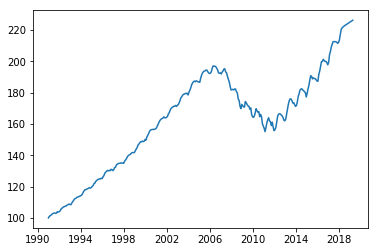

ESC


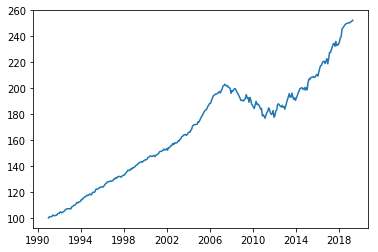

MA


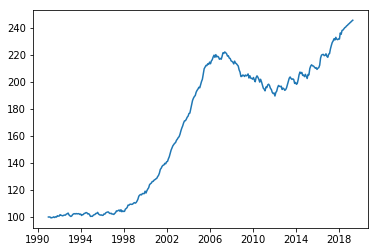

MT


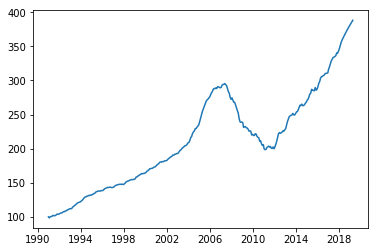

NE


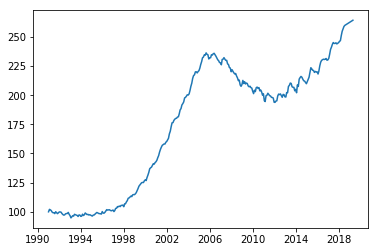

PAC


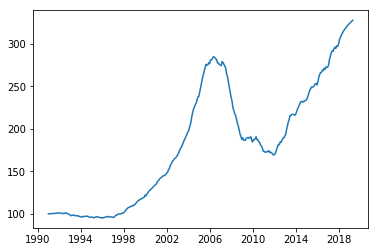

SA


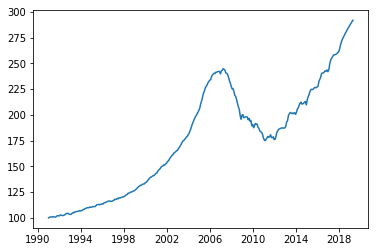

WNC


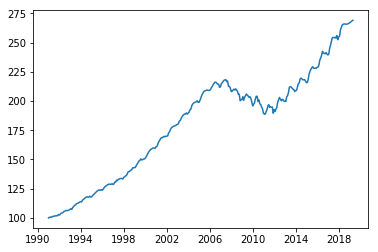

WSC


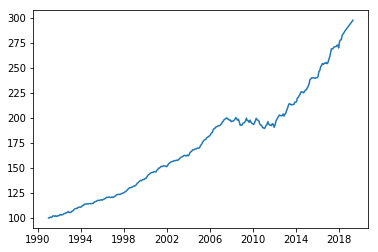

USA


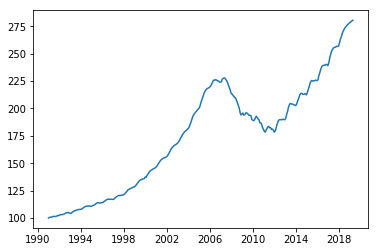

In [16]:
for col in new_div_po_monthly.columns:
    print col
    plt.plot(new_div_po_monthly[col])
    plt.show()

# po quarterly

In [17]:
%reset -f 
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 
from dateutil.relativedelta import relativedelta

Populating the interactive namespace from numpy and matplotlib


In [18]:

def shell_run_and_wait(command):
    print command
    command = command.split(" ")
    import subprocess
    #process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    process = subprocess.Popen(command)
    process.wait()
    return process.returncode


In [19]:
sys.path.insert(0,'/opt/R/R-3.4.2-intel-mkl/bin')

In [20]:
if os.path.exists('/opt/R/R-3.4.2-intel-mkl/bin/Rscript'):
    RCMD='/opt/R/R-3.4.2-intel-mkl/bin/Rscript'
else:
    RCMD=!which Rscript
    assert RCMD
    RCMD=RCMD[0]

In [21]:
master = pd.read_csv('https://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_master.csv')

In [22]:
def read_po_quarterly_hpi():
    df=master[(master['frequency']=='quarterly') & (master['level']=='State') 
       & (master['hpi_type']=='traditional') & (master['hpi_flavor']=='purchase-only')]
    df=df[df['place_id'].isin({'CA','OH','NC','IA','NY'})]
    m={1:2,2:5,3:8,4:11}
    df['month'] = df[['yr','period']].apply(lambda u: pd.to_datetime('{}-{}-1'.format(u.values[0],m[u.values[1]]-1)),axis=1)
    df=pd.pivot_table(df,index=['month'], columns=['place_id'],values=['index_nsa'] )
    df.columns = df.columns.droplevel()
    df.columns=df.columns.map(lambda u: u.replace("DV_",""))
    #df=df[["MA",'ENC','WNC','SA','PAC']]    
    return df 

In [23]:
state_po_quarterly=read_po_quarterly_hpi()

In [24]:
state_po_quarterly.tail()

place_id        CA      IA      NC      NY      OH
month                                             
2017-01-01  255.24  230.00  220.06  225.57  183.31
2017-04-01  265.02  235.84  231.17  230.91  192.41
2017-07-01  269.43  240.18  230.80  236.75  195.50
2017-10-01  272.13  239.46  233.36  239.01  194.49
2018-01-01  277.87  239.88  238.69  239.58  196.82

In [25]:
def do_predict(div_po_monthly):
    div_po_monthly=div_po_monthly.copy()
    inputfile="/tmp/state_po_quarterly.csv"
    outputfile= inputfile+".rpred"
    div_po_monthly.to_csv(inputfile)
    code=shell_run_and_wait("{} ./arimmaforeast.R --input {} --output {} --freq 4 --nthread 2".format(RCMD,inputfile,outputfile))
    assert code==0, code
    pred=pd.read_csv(outputfile,header=None).values
    print pred.shape
    assert np.isnan(pred).sum()==0
    max_month=div_po_monthly.index.max()
    for i in range(pred.shape[0]):
        max_month=max_month+relativedelta(months=3)
        div_po_monthly.loc[max_month]=pred[i]
    return div_po_monthly.sort_index()

In [26]:
new_state_po_quarterly=do_predict(state_po_quarterly)

/opt/R/R-3.4.2-intel-mkl/bin/Rscript ./arimmaforeast.R --input /tmp/state_po_quarterly.csv --output /tmp/state_po_quarterly.csv.rpred --freq 4 --nthread 2
(12, 5)


In [27]:
new_state_po_quarterly.tail()

place_id            CA          IA          NC          NY          OH
month                                                                 
2020-01-01  303.966597  250.241481  261.720298  263.025344  205.871036
2020-04-01  307.633588  251.536667  263.801047  267.090930  206.786486
2020-07-01  308.274041  252.831852  265.766500  271.804153  207.701936
2020-10-01  307.304247  254.127037  267.636111  272.779026  208.617386
2021-01-01  308.909655  255.422222  269.426052  272.872771  209.532836

In [28]:
new_state_po_quarterly.to_csv("../input/third2/HPI_state_PO_quarterly_hist_with_forecast_arima.csv")

CA


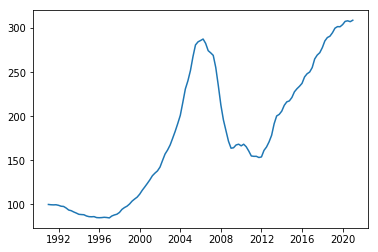

IA


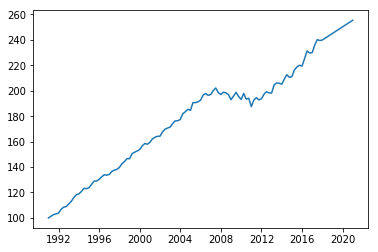

NC


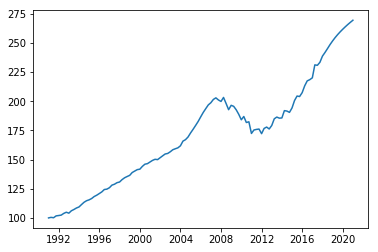

NY


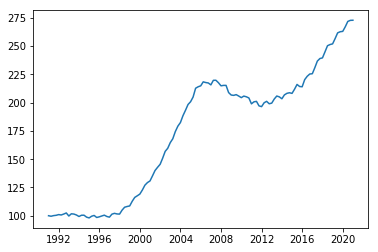

OH


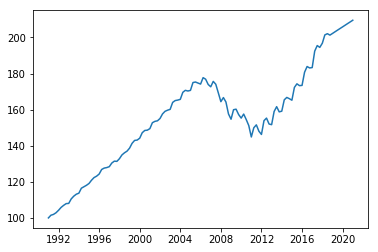

In [29]:
for col in new_state_po_quarterly.columns:
    print col
    plt.plot(new_state_po_quarterly[col])
    plt.show()

# AT

In [30]:
%reset -f 
%pylab inline
import pandas as pd
import dask.dataframe as dd
import os,sys
import logging
import fastparquet
import gc
import cPickle as pickle 
from dateutil.relativedelta import relativedelta

Populating the interactive namespace from numpy and matplotlib


In [31]:

def shell_run_and_wait(command):
    print command
    command = command.split(" ")
    import subprocess
    #process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    process = subprocess.Popen(command)
    process.wait()
    return process.returncode


In [32]:
sys.path.insert(0,'/opt/R/R-3.4.2-intel-mkl/bin')

In [33]:
if os.path.exists('/opt/R/R-3.4.2-intel-mkl/bin/Rscript'):
    RCMD='/opt/R/R-3.4.2-intel-mkl/bin/Rscript'
else:
    RCMD=!which Rscript
    assert RCMD
    RCMD=RCMD[0]

In [34]:
master = pd.read_csv('https://www.fhfa.gov/DataTools/Downloads/Documents/HPI/HPI_master.csv')

In [35]:
set(master['hpi_flavor'])

{'all-transactions', 'expanded-data', 'purchase-only'}

In [36]:
def read_po_quarterly_hpi():
    df=master[(master['frequency']=='quarterly') & (master['level']=='State') 
       & (master['hpi_type']=='traditional') & (master['hpi_flavor']=='all-transactions')]
    df=df[df['place_id'].isin({'CA','OH','NC','IA','NY'})]
    m={1:2,2:5,3:8,4:11}
    df['month'] = df[['yr','period']].apply(lambda u: pd.to_datetime('{}-{}-1'.format(u.values[0],m[u.values[1]]-1)),axis=1)
    df=pd.pivot_table(df,index=['month'], columns=['place_id'],values=['index_nsa'] )
    df.columns = df.columns.droplevel()
    df.columns=df.columns.map(lambda u: u.replace("DV_",""))
    #df=df[["MA",'ENC','WNC','SA','PAC']]    
    return df 

In [37]:
state_po_quarterly=read_po_quarterly_hpi()

In [38]:
state_po_quarterly.tail()

place_id        CA      IA      NC      NY      OH
month                                             
2017-01-01  590.62  281.18  347.59  633.52  267.10
2017-04-01  604.36  285.79  360.10  644.83  276.95
2017-07-01  616.05  290.88  364.07  657.60  281.04
2017-10-01  627.10  292.17  366.19  664.39  281.40
2018-01-01  638.37  292.24  372.17  671.41  283.87

In [39]:
def do_predict(div_po_monthly):
    div_po_monthly=div_po_monthly.copy()
    inputfile="/tmp/state_po_quarterly.csv"
    outputfile= inputfile+".rpred"
    div_po_monthly.to_csv(inputfile)
    code=shell_run_and_wait("{} ./arimmaforeast.R --input {} --output {} --freq 4 --nthread 2".format(RCMD,inputfile,outputfile))
    assert code==0, code
    pred=pd.read_csv(outputfile,header=None).values
    print pred.shape
    assert np.isnan(pred).sum()==0
    max_month=div_po_monthly.index.max()
    for i in range(pred.shape[0]):
        max_month=max_month+relativedelta(months=3)
        div_po_monthly.loc[max_month]=pred[i]
    return div_po_monthly.sort_index()

In [40]:
new_state_po_quarterly=do_predict(state_po_quarterly)

/opt/R/R-3.4.2-intel-mkl/bin/Rscript ./arimmaforeast.R --input /tmp/state_po_quarterly.csv --output /tmp/state_po_quarterly.csv.rpred --freq 4 --nthread 2
(12, 5)


In [41]:
new_state_po_quarterly.tail()

place_id            CA          IA          NC          NY          OH
month                                                                 
2020-01-01  687.081723  308.183800  405.457821  727.222006  307.501877
2020-04-01  689.492014  309.950928  408.488223  733.152451  310.341974
2020-07-01  691.551655  311.691718  411.130625  738.869404  312.612499
2020-10-01  693.382735  313.408794  413.880775  744.402799  314.723002
2021-01-01  695.061167  315.103852  416.327468  749.787974  317.128029

In [42]:
new_state_po_quarterly.to_csv("../input/third2/HPI_state_AT_quarterly_hist_with_forecast_arima.csv")

CA


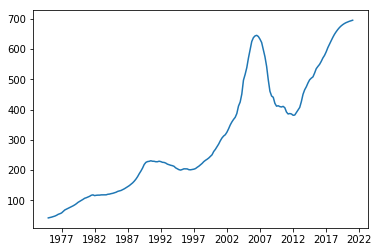

IA


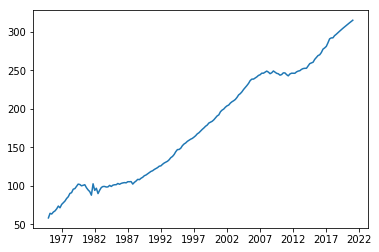

NC


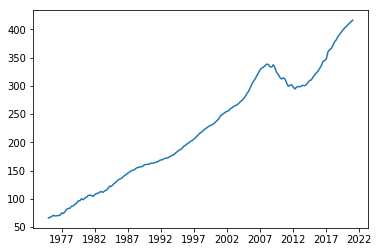

NY


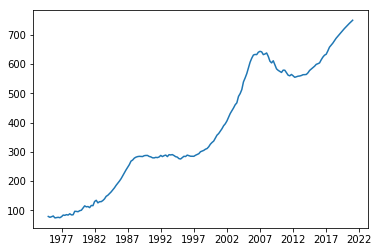

OH


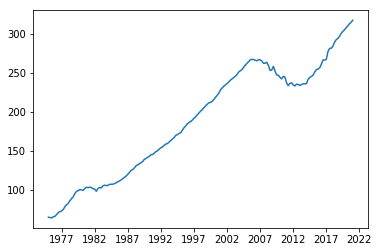

In [43]:
for col in new_state_po_quarterly.columns:
    print col
    plt.plot(new_state_po_quarterly[col])
    plt.show()